
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation of historical nearshore waves

inputs required: 
  * Nearshore reconstructed historical **waves**
  * Reef morphology of the 36 profiles
  * Historical water levels

in this notebook:
  * HyCReWW-Q overtopping estimation of historical events
  

**HyCReWW - Q** provides wave-driven overtopping estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of overtopping for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_{reef}$, $\beta_b$, $c_f$, $Z_b$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), seabed roughness ($c_f$) and beach crest elevation ($Z_b$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period.

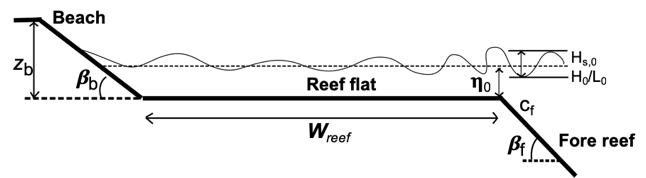

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# Load historical TWL
level = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/TIDE/hist_TWL.nc'))

# --------------
# SLR +0.5
level['TWL'] = level['TWL']+0.5


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW_Q()

# reef characteristics (AlbaR)
xds_reef = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_albaR','data_profiles.nc'))
xds_reef = xds_reef.drop('zBeach')
print(xds_reef)
print()

# Zbeach characteristics (Sara)
xds_Zbeach = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_sara','zBeach_clean_P1.nc'))
xds_Zbeach = xds_Zbeach.drop({'xcoor', 'ycoor'})
print(xds_Zbeach)
print()


# --------------------------------------
# Load nearshore waves
WAVES_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_N.nc')) # hourly
WAVES_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_S.nc')) # 3-hourly
WAVES_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_E.nc')) # 3-hourly

# to hourly and same dates
WAVES_N = WAVES_N.sel(time=slice(WAVES_S.time.values[0], WAVES_S.time.values[-1]))
WAVES_S = WAVES_S.resample(time='1H').interpolate('linear')
WAVES_E = WAVES_E.resample(time='1H').interpolate('linear')

# join in one file
WAVES_S = WAVES_S.drop({'tm','dirP','dates_sea', 'dates_swell'})
WAVES_E = WAVES_E.drop({'tm','dirP','dates_sea', 'dates_swell'})

WAVES = xr.concat([WAVES_N, WAVES_S, WAVES_E], dim='profile')
print(WAVES)
print()


<xarray.Dataset>
Dimensions:      (profile: 36)
Coordinates:
  * profile      (profile) int64 36 35 34 33 32 31 30 29 28 ... 8 7 6 5 4 3 2 1
Data variables:
    Wreef        (profile) int64 ...
    Fore Slope   (profile) float64 ...
    Beach Slope  (profile) float64 ...
    Toe Fore     (profile) int64 ...
    Lon Start    (profile) float64 ...
    Lon End      (profile) float64 ...
    Lat Start    (profile) float64 ...
    Lat End      (profile) float64 ...

<xarray.Dataset>
Dimensions:  (profile: 36)
Coordinates:
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    zBeach   (profile) float64 ...

<xarray.Dataset>
Dimensions:  (profile: 36, time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
  * profile  (profile) float64 22.0 23.0 24.0 25.0 26.0 ... 18.0 19.0 20.0 21.0
Data variables:
    hs       (time, profile) float64 0.5726 0.5733 0.5745 ... 1.759 1.759 1.615
    tp       (ti


## Hycreww RBF Interpolation

### VARIABLES

##### Set parameters for Hycreww: TWL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [3]:
# Combine the 3 datasets (waves, reef characteristics and the modified Zbeach)

xds_reef_t = xr.Dataset(
            {   'bslope':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Beach Slope'].values),
                'rslope':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Fore Slope'].values),
                'rwidth':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Wreef'].values),                
                'cf':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*0.1),
            },
    coords = {'time': WAVES.time.values,
              'profile': xds_reef.profile.values})

xds_Zbeach_t = xr.Dataset(
            {   'Zb':(('time','profile'), np.ones((len(WAVES.time),len(xds_Zbeach.profile)))*xds_Zbeach['zBeach'].values),                
            },
    coords = {'time': WAVES.time.values,
              'profile': xds_Zbeach.profile.values})


dset = xr.merge([WAVES, xds_reef_t, xds_Zbeach_t])
print(dset)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 359401)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    hs       (time, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tp       (time, profile) float64 nan nan nan nan ... 3.705 3.705 3.705 3.705
    dir      (time, profile) float64 0.0 0.0 0.0 0.0 ... 181.6 175.2 179.1 186.0
    bslope   (time, profile) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.02 0.02 0.02 0.02
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 2.646 3.222 2.623 ... 2.844 2.434 2.789


In [4]:
# Add needed Hycreww params

dset = dset.sel(time=level.time)

level_t = np.tile(level.TWL.sel(time=dset.time).values, (36,1))
level_t = np.transpose(level_t)

dset['level'] = (('time','profile'), level_t)

dset['hs_lo2'] = (dset.hs/(1.5613*dset.tp**2))

print(dset)

<xarray.Dataset>
Dimensions:  (profile: 36, time: 350268)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tp       (time, profile) float64 nan nan nan nan ... 2.517 2.517 2.517 2.517
    dir      (time, profile) float64 0.0 0.0 0.0 0.0 ... 174.9 168.6 172.3 179.2
    bslope   (time, profile) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.02 0.02 0.02 0.02
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 2.646 3.222 2.623 ... 2.844 2.434 2.789
    level    (time, profile) float64 -0.3873 -0.3873 -0.3873 ... 0.5757 0.5757
    hs_lo2   (time, profile) float64 nan 

In [5]:
# Adjust variables to fit within Hycreww limits
print(var_lims.keys())

for var in var_lims.keys():
    
    dset[var] =  dset[var].where(dset[var]>=var_lims[var][0], var_lims[var][0] )
    dset[var] =  dset[var].where(dset[var]<=var_lims[var][1], var_lims[var][1] )    
    

print(dset)


dict_keys(['level', 'hs', 'tp', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf', 'hs_lo2'])
<xarray.Dataset>
Dimensions:  (profile: 36, time: 350268)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time, profile) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    tp       (time, profile) float64 3.4 3.4 3.4 3.4 3.4 ... 3.4 3.4 3.4 3.4 3.4
    dir      (time, profile) float64 0.0 0.0 0.0 0.0 ... 174.9 168.6 172.3 179.2
    bslope   (time, profile) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 2.646 3.222 2.623 ... 2.844 2.434 2.789
    level    (time, profile) float6

### HyCReWW-Q

In [6]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.time)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()  
    dset_out['Q'] = (('time'),Q)

    return dset_out

In [7]:
# Compute Hycreww-Q

for p in dset.profile.values:
    print(p)
    
    dset_p = dset.sel(profile=p)

    out_sim_p = hycreww_Q(var_lims, rbf_coeffs, dset_p)
        
    if p==1:
        out_sim = out_sim_p
    else:
        out_sim = xr.concat([out_sim, out_sim_p], dim='profile')
    
    
print(out_sim)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
<xarray.Dataset>
Dimensions:  (profile: 36, time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    tp       (profile, time) float64 3.4 3.4 3.4 3.4 4.395 ... 3.4 3.4 3.4 3.4
    dir      (profile, time) float64 0.0 54.41 108.8 163.2 ... 190.7 182.0 179.2
    bslope   (profile, time) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (profile, time) float64 235.0 235.0 235.0 235.0 ... 0.0 0.0 0.0 0.0
    cf       (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (profile, time

### We undo the box-cox transformation

In [8]:
from scipy.special import boxcox, inv_boxcox

# inv_boxcox(y, lmbda) 
# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#     log(x)                  if lmbda == 0
    
out_sim['Qinv'] = (('profile', 'time'), inv_boxcox(out_sim.Q.values, 0.2))

print(out_sim)

<xarray.Dataset>
Dimensions:  (profile: 36, time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    tp       (profile, time) float64 3.4 3.4 3.4 3.4 4.395 ... 3.4 3.4 3.4 3.4
    dir      (profile, time) float64 0.0 54.41 108.8 163.2 ... 190.7 182.0 179.2
    bslope   (profile, time) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (profile, time) float64 235.0 235.0 235.0 235.0 ... 0.0 0.0 0.0 0.0
    cf       (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (profile, time) float64 2.646 2.646 2.646 ... 2.789 2.789 2.789
    level    (profile, time) float64 -0.3873 -0.2369 0.07976 ... 0.5526 0.5757
    hs_lo2   (profile, time) float64 0.005

In [9]:
# Save

out_sim.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH_SLR05.nc'))


### Plot

In [10]:
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

out_sim_N = out_sim.sel(profile=pN)
out_sim_S = out_sim.sel(profile=pS)
out_sim_E = out_sim.sel(profile=pE)

out_sim_N = out_sim_N.drop('profile')
out_sim_S = out_sim_S.drop('profile')
out_sim_E = out_sim_E.drop('profile')



Text(0.5, 0.98, 'Overtopping (l/s/m)')

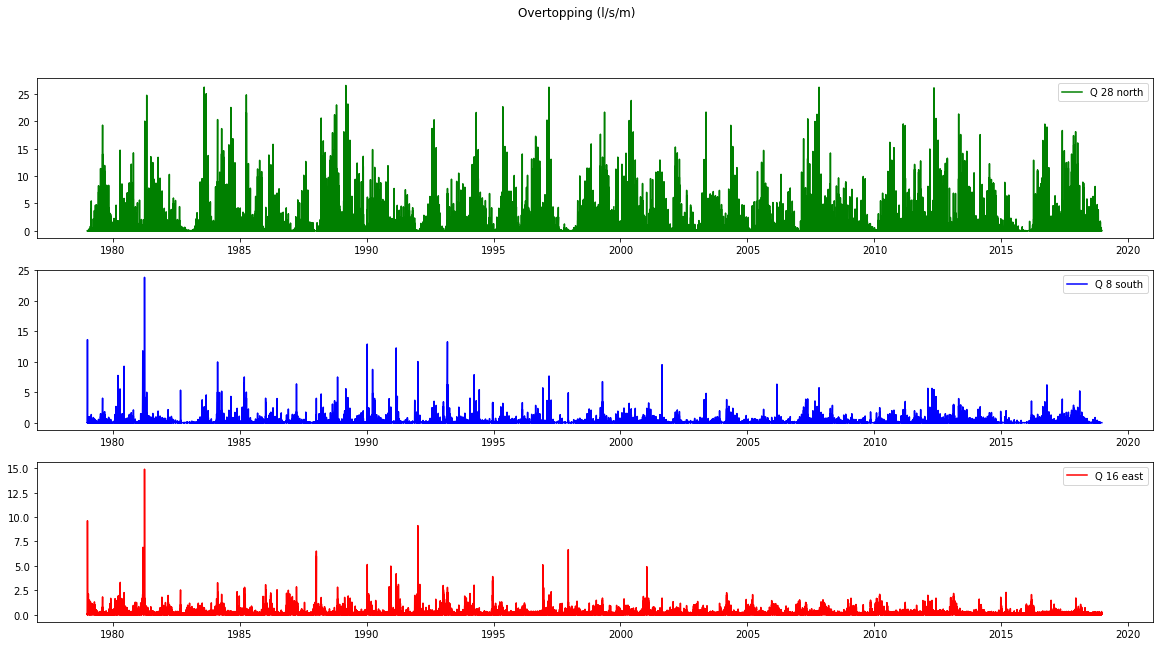

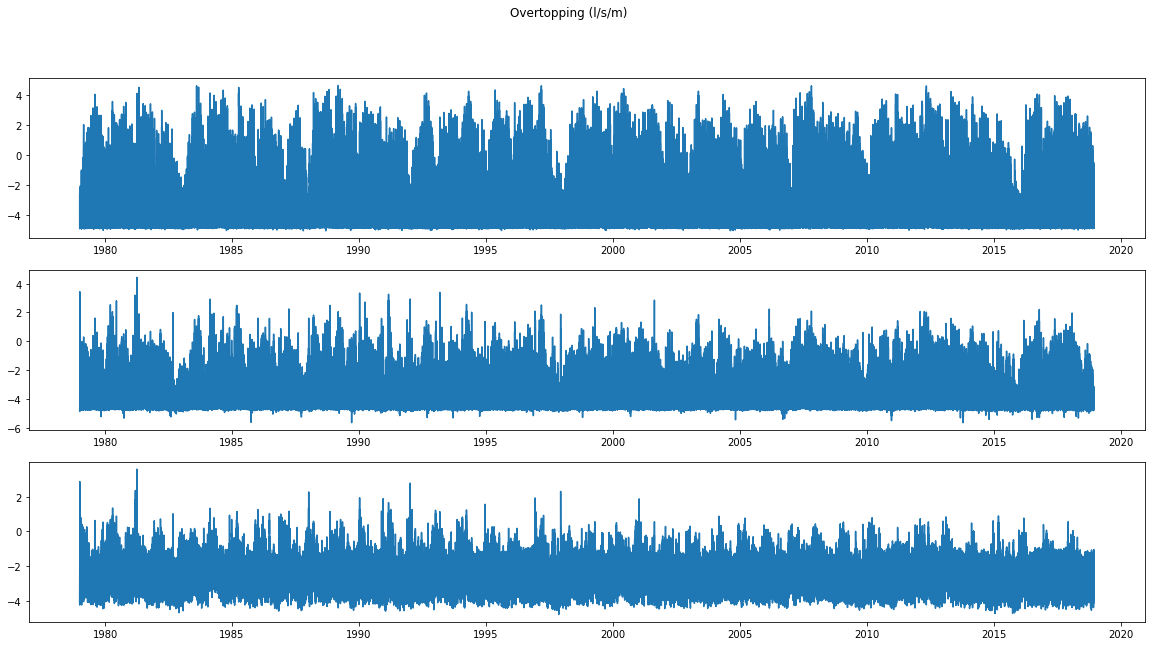

In [11]:
fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Qinv, color='g', label='Q ' + str(pN) + ' north')
axs[1].plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q ' + str(pS) + ' south')
axs[2].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q ' + str(pE) + ' east')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle('Overtopping (l/s/m)')


fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Q, label='Q ' + str(pN) + ' north')
axs[1].plot(out_sim_S.time, out_sim_S.Q, label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Q, label='Q East')

plt.suptitle('Overtopping (l/s/m)')

#### Plot results for East profile

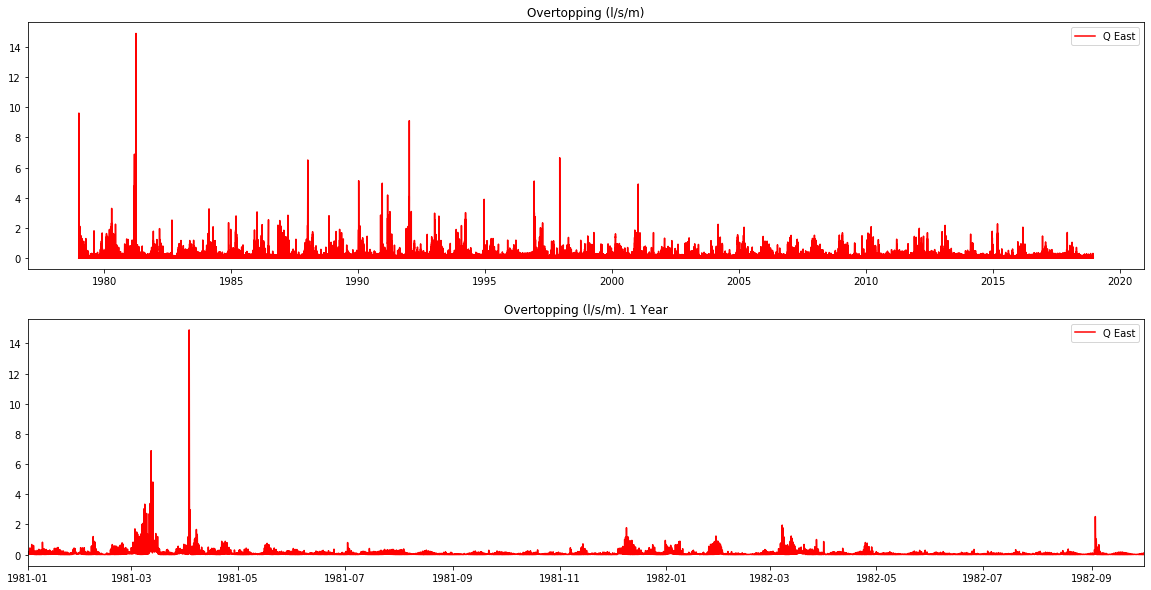

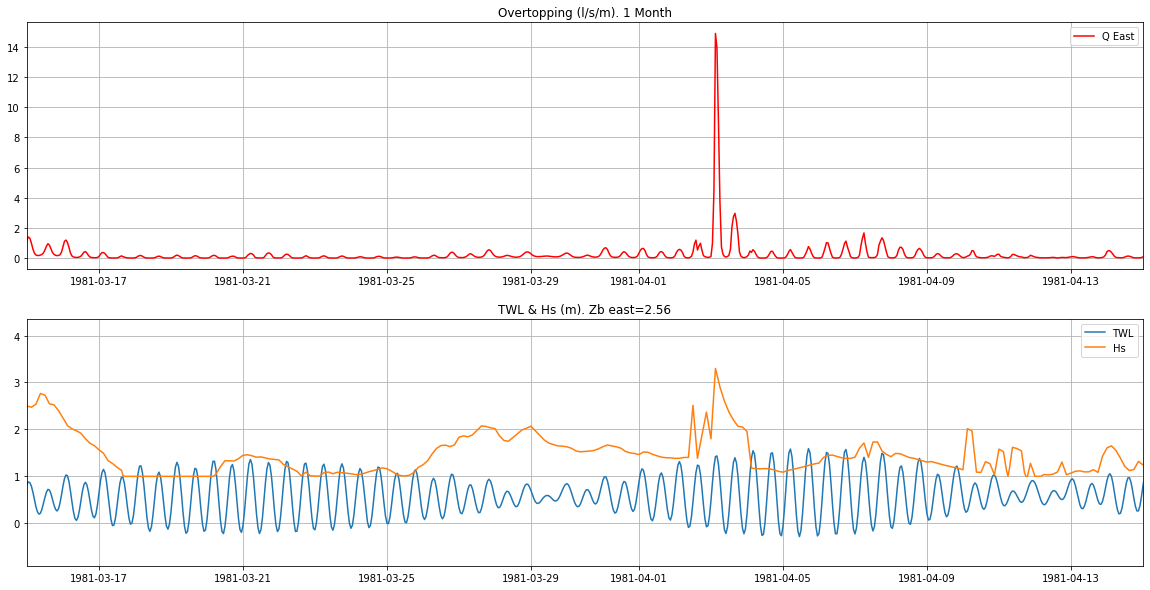

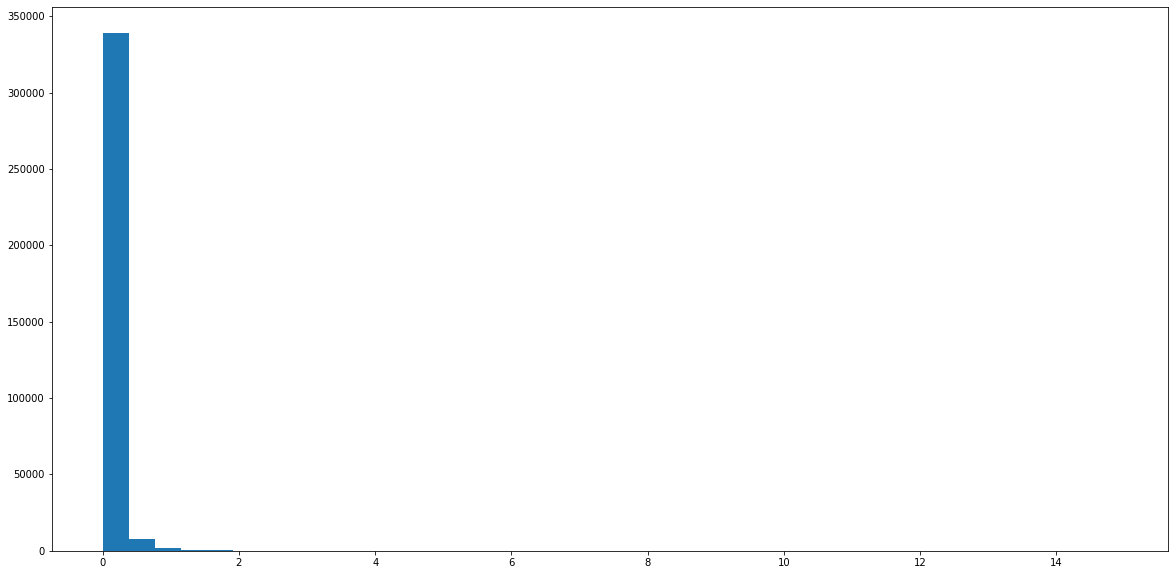

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100. ]

[1.47839194e-07 4.65938343e-04 8.83671249e-04 1.33551442e-03
 1.84726881e-03 2.42998168e-03 3.05952191e-03 3.76027747e-03
 4.52798671e-03 5.37482959e-03 6.27925305e-03 7.29078518e-03
 8.37946022e-03 9.54175896e-03 1.08567383e-02 1.22984770e-02
 1.39058484e-02 1.56617771e-02 1.76243172e-02 1.98369628e-02
 2.23077820e-02 2.49733850e-02 2.79903929e-02 3.13328808e-02
 3.51608035e-02 3.94140511e-02 4.41377583e-02 4.94096061e-02
 5.53503806e-02 6.22622983e-02 7.02539987e-02 7.95364328e-02
 9.05194092e-02 1.03738535e-01 1.19423087e-01 1.40274009e-01
 1.68333803e-01 2.09951947e-01 2.83657434e-01 4.50126478e-01
 1.48917046e+01]


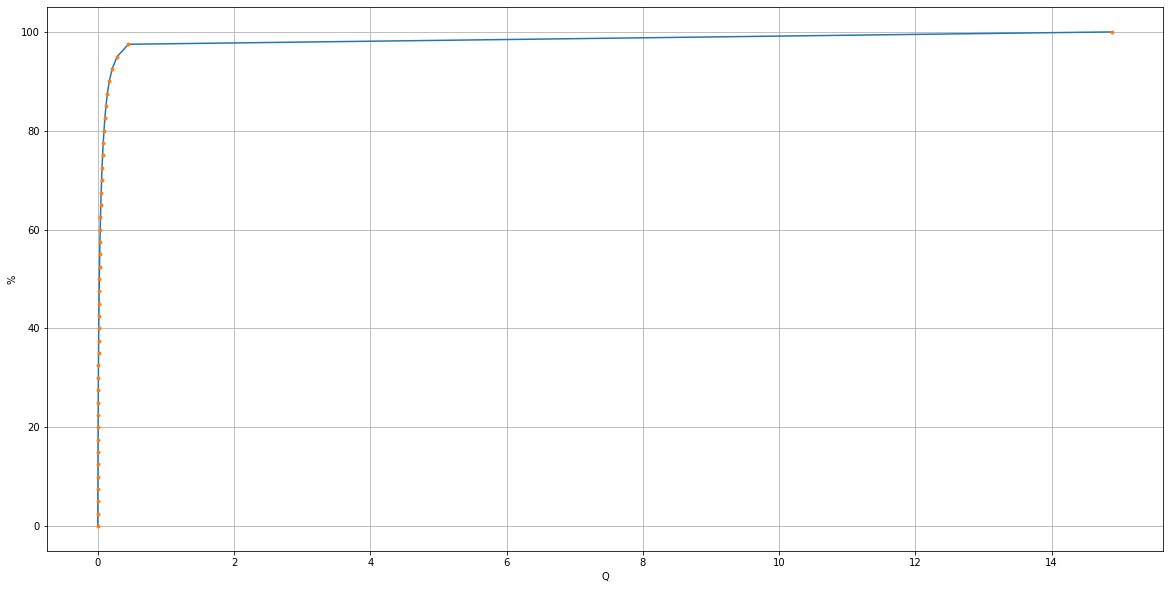

In [12]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m)')

# zoom 1 year
axs[1].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[1].legend()
axs[1].set_title('Overtopping (l/s/m). 1 Year')
#axs[1].set_xlim(datetime(2000,10,1),datetime(2001,10,1))
axs[1].set_xlim(datetime(1981,1,1),datetime(1982,10,1))

# zoom 1 month
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m). 1 Month')
#axs[0].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[0].set_xlim(datetime(1981,3,15),datetime(1981,4,15))
axs[0].grid()

# plot TWL
axs[1].plot(level.time, level.TWL, label = 'TWL')
axs[1].plot(out_sim_E.time, out_sim_E.hs, label = 'Hs')
axs[1].legend()
#axs[1].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[1].set_xlim(datetime(1981,3,15),datetime(1981,4,15))
#axs[1].set_ylim(-1, 2.5)
axs[1].set_title('TWL & Hs (m). Zb east=' + str(round(out_sim_E.Zb.values[0],2)))
axs[1].grid()


# histogram
plt.figure(figsize=(20,10))
bins_number = 40 #100 
bins = np.linspace(np.nanmin(out_sim_E.Qinv.values), np.nanmax(out_sim_E.Qinv.values), bins_number)

n, _, _ = plt.hist(out_sim_E.Qinv.values, bins)
plt.show()

# percentiles
q = np.linspace(0,100,bins_number+1)
perc = np.nanpercentile(out_sim_E.Qinv.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('Q')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)